# Path Planning

Created by Kevin J. Walchko 25 July 2017

----

Based off Sabastian Thur's Robotic course, Udacity.com and some good material from Red Games.

## References

- [Standford DARPA Grand Challenge](https://www.youtube.com/watch?v=qXZt-B7iUyw)
- [RedGames blog, deep dive on A\*](http://www.redblobgames.com/pathfinding/a-star/implementation.html)
- [RedGames blog, Intro to A\*](http://www.redblobgames.com/pathfinding/a-star/introduction.html)
- [Wikipedia A\*](https://en.wikipedia.org/wiki/A*_search_algorithm)

## Setup

In [34]:
%matplotlib inline

from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np

# Path Finding

There are alot of algorithms out there to do path planning in 2D and 3D environments. Three useful algorithms are:

- **Breadth First Search:** explores equally in all directions. This is an incredibly useful algorithm, not only for regular path finding, but also for procedural map generation, flow field pathfinding, distance maps, and other types of map analysis.
- **Dijkstra’s Algorithm:** (also called Uniform Cost Search) lets us prioritize which paths to explore. Instead of exploring all possible paths equally, it favors lower cost paths. We can assign lower costs to encourage moving on roads, higher costs to avoid forests, higher costs to discourage going near enemies, and more. When movement costs vary, we use this instead of Breadth First Search.
- **A\*:** is a modification of Dijkstra’s Algorithm that is optimized for a single destination. Dijkstra’s Algorithm can find paths to all locations; A* finds paths to one location. It prioritizes paths that seem to be leading closer to the goal.

Now I point these out because they are all related.

- Breadth First Search (BFS) is a one to many path finder, but all paths found have equal cost. BFS will search the entire search space
- Dijkstra's Algorithm builds on BFS by adding a cost function and allows you to various things like toll roads, highways, surface streets, etc. It also searches the entire search space in all directions
- A\* is different that the first 2 because it is a one to one (start point to finish piont) path finder with a cost function. A\* will stop searching once it reaches the finish point and may leave regions of the map unexplored

In computer science, A\* (pronounced as "A star") is a computer algorithm that is widely used in pathfinding and graph traversal, the process of plotting an efficiently directed path between multiple points, called nodes. It enjoys widespread use due to its performance and accuracy. 

Peter Hart, Nils Nilsson and Bertram Raphael of Stanford Research Institute (now SRI International) first described the algorithm in 1968. It is an extension of Edsger Dijkstra's 1959 algorithm. A\* achieves better performance by using heuristics to guide its search. 

In [84]:
def drawMap(grid, path=None, cmap='binary', title=None):
    """
    Draw the map
    grid - map to draw
    path - if a path is given, it will draw the path as a gray color
    cmap - if given, will use the cmap and display colorbar
    title - if given, will set the title
    startstop - if given, will display the start/stop locations
    """
    rows = len(grid)
    cols = len(grid[0])
    data = np.ones((rows, cols))
    vmax = -1
    
    fig, ax = plt.subplots(1, 1, tight_layout=True)
    
    # NOTE: binary is backwards:
    # 0 - white
    # 255 - black
    if cmap is 'binary':
        for i, r in enumerate(grid):
            for j, c in enumerate(r):
                data[i,j] = 255 if c else 0
        if path:
            for pt in path:
                y, x = pt
                data[y, x] = 100
    else:
        for i, r in enumerate(grid):
            for j, c in enumerate(r):
                data[i,j] = c
                vmax = c if c > vmax else vmax
        
    
#     fig, ax = plt.subplots(1, 1, tight_layout=True)
    
    # make color map
#     my_cmap = matplotlib.colors.ListedColormap(['r', 'g', 'b'])
    
    # set the 'bad' values (nan) to be white and transparent
#     my_cmap.set_bad(color='w', alpha=0)
    
    # draw the grid
    for x in range(rows+1):
        ax.axhline(x, lw=2, color='k', zorder=rows)
        
    for x in range(cols+1):
        ax.axvline(x, lw=2, color='k', zorder=cols)
        
    # draw the boxes
    cax = ax.imshow(data, interpolation='none', cmap=cmap, extent=[0, cols, 0, rows], zorder=0)
    
    # only draw colorbar if we aren't in binary mode
    if cmap is not 'binary':
#         fig.colorbar(cax, ticks=[0, vmax])
        fig.colorbar(cax, ticks=range(0, vmax+1, vmax//5))
    
    # turn off the axis labels
    ax.axis('off')
    
    if title:
        ax.set_title(title)

        
def getPath(expand, goal, start, wall=-1):
    path = []
    x, y = goal
    val = expand[x][y]
    delta = [
        [-1, 0 ], # go up
        [ 0, -1], # go left
        [ 1, 0 ], # go down
        [ 0, 1 ]  # go right
    ]
    done = False
    max_x_grid = len(grid)
    max_y_grid = len(grid[0])
    
    path.append(goal)
    
    while not done:
        vals = []
        for move in delta:
            x2, y2 = x + move[0], y + move[1]
            # make sure still on map
            if x2 >= 0 and x2 < max_x_grid and y2 >=0 and y2 < max_y_grid:
                if expand[x2][y2] > wall:  # don't travel through walls
                    val = expand[x2][y2]
                    vals.append((val, move))

        lowest = 100000
        for v, m in vals:
            if v < lowest:
                move = m
                lowest = v

        x, y = x + move[0], y + move[1]
        path.append([x, y])
        
        if x == start[0] and y == start[1]:
            done = True
        
    return path

## Simple Search

This method searches through an entire map and determines the cost of moving from the starting point.

`simpmle_search`:

- grid: the map
- init: the starting point
- goal: where you want to get too
- cost: movement cost

In [42]:
def simple_search(grid,init,goal,cost):
    closed = [[0 for row in range(len(grid[0]))] for col in range(len(grid))]
    closed[init[0]][init[1]] = 1
    
    open = [[0, init[0], init[1]]]
    
    delta = [[-1, 0], # go up
             [ 0,-1], # go left
             [ 1, 0], # go down
             [ 0, 1]] # go right

    found = False  # flag that is set when search is complete
    resign = False # flag set if we can't find expand
    
    while not found and not resign:
        if len(open) == 0:
            print('<<< Fail: cannot find path to goal >>>')
            resign = True
        else:
            # remove node from list
            open.sort()  # sorts from small to large
            open.reverse()  # reverses: large to small
            next = open.pop()  # removes last element (smallest number)
            g, x, y = next
            
            if x == goal[0] and y == goal[1]:
                found = True
                print('found:', next)
            else:
                # cycle through possible movements
                for d in delta:
                    x2, y2 = x+d[0], y+d[1]
                    if x2 >= 0 and x2 < len(grid) and y2 >= 0 and y2 < len(grid[0]):
#                         print('checking:', x2, y2)
                        # check unoccupied
                        if closed[x2][y2] == 0 and grid[x2][y2] == 0:
                            g2 = g + cost  # increment g value
                            open.append([g2, x2, y2])
                            closed[x2][y2] = g2

    return closed

found: [15, 4, 5]
start [0, 0]
goal [4, 5]
[[4, 5], [3, 5], [2, 5], [1, 5], [1, 4], [1, 3], [2, 3], [3, 3], [4, 3], [4, 2], [4, 1], [3, 1], [3, 0], [2, 0], [1, 0], [0, 0]]


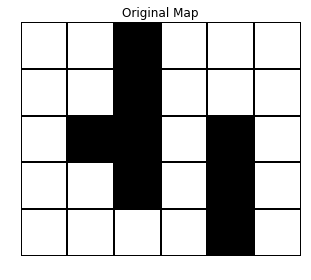

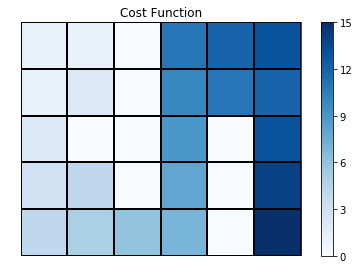

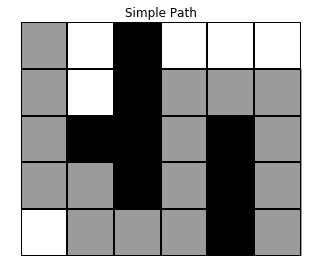

In [83]:
grid = [[0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 1, 1, 0, 1, 0],
        [0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 1, 0]
       ]

init = [0, 0]
goal = [4, 5]

goal2 = [len(grid)-1, len(grid[0])-1]

drawMap(grid, title='Original Map')
cost = simple_search(grid, init, goal, 1)

drawMap(cost, cmap='Blues', title='Cost Function')

print('start', init)
print('goal', goal)
path = getPath(cost, goal, init,0)
print(path)

drawMap(grid, path, title='Simple Path')

In [64]:
# printMap(grid)
# printPath(path, grid)

## A\*

blah ...

In [65]:
def a_star(grid,init,goal,cost,heuristic):
    # ----------------------------------------
    # modify the code below
    # ----------------------------------------
    closed = [[0 for col in range(len(grid[0]))] for row in range(len(grid))]
    closed[init[0]][init[1]] = 1

    expand = [[-1 for col in range(len(grid[0]))] for row in range(len(grid))]
    action = [[-1 for col in range(len(grid[0]))] for row in range(len(grid))]
    
    
    delta = [[-1, 0], # go up
             [ 0,-1], # go left
             [ 1, 0], # go down
             [ 0, 1]] # go right

    x, y = init
    g = 0
    h = heuristic[x][y]
    f = g + h

    open = [[f, g, x, y]]  # add f

    found = False  # flag that is set when search is complete
    resign = False # flag set if we can't find expand
    count = 0
    
    while not found and not resign:
        if len(open) == 0:
            resign = True
            return "Fail"
        else:
            open.sort()
            open.reverse()
            next = open.pop()
            x = next[2]
            y = next[3]
            g = next[1]
            expand[x][y] = count
            count += 1
            
            if x == goal[0] and y == goal[1]:
                found = True
            else:
                # expand winning element and add to new open list
                for i in range(len(delta)):
                    x2 = x + delta[i][0]
                    y2 = y + delta[i][1]
                    # make sure still on map
                    if x2 >= 0 and x2 < len(grid) and y2 >=0 and y2 < len(grid[0]):
                        # make sure unoccuppied
                        if closed[x2][y2] == 0 and grid[x2][y2] == 0:
                            g2 = g + cost
                            h2 = heuristic[x2][y2]
                            f2 = g2 + h2
                            open.append([f2, g2, x2, y2])
                            closed[x2][y2] = 1

    return expand

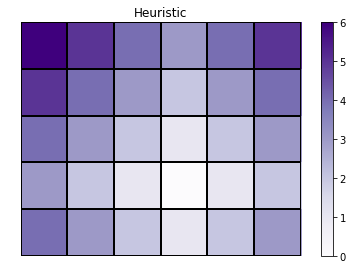

In [66]:
def calcHeuristic(grid, goal):
    """
    Basically calculates a gradient decent from a given
    goal point.
    """
    w = len(grid[0])  # width
    h = len(grid)     # height
    hr = [[(abs(goal[1]-y)+abs(goal[0]-x)) for y in range(w)] for x in range(h)]
    return hr

g = [3, 3]
hr = calcHeuristic(grid, g)
drawMap(hr, cmap='Purples', title='Heuristic')

start [0, 0]
goal [4, 5]


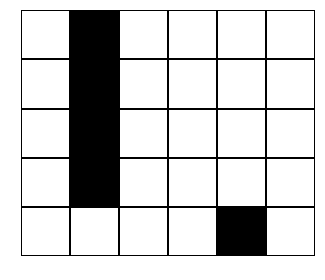

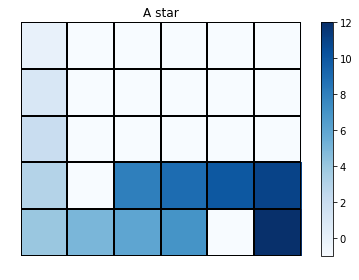

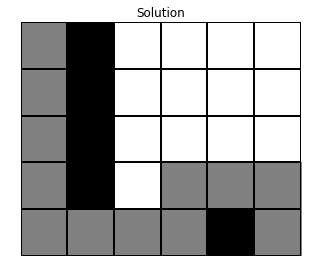

In [67]:
grid = [[0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0]]

drawMap(grid)
# heuristic = [[9, 8, 7, 6, 5, 4],
#              [8, 7, 6, 5, 4, 3],
#              [7, 6, 5, 4, 3, 2],
#              [6, 5, 4, 3, 2, 1],
#              [5, 4, 3, 2, 1, 0]]

init = [0, 0]
goal = [len(grid)-1, len(grid[0])-1]

heuristic = calcHeuristic(grid, goal)
cost = 1

ans = a_star(grid,init,goal,cost,heuristic)
drawMap(ans, cmap='Blues', title='A star')
print('start', init)
print('goal', goal)
path = getPath(ans, goal, init)
drawMap(grid, path, title='Solution')


Now the thing to notice is, the heuristic pulls the path planner towards the goal like a rubber band. It drives to search algorithm to the end and avoids exploring unnecessary space in the map. This can be seen in the middle plot, where there are -1's in open space because it wasn't explored.

TypeError: unsupported operand type(s) for +: 'int' and 'list'

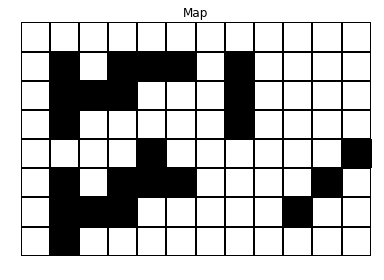

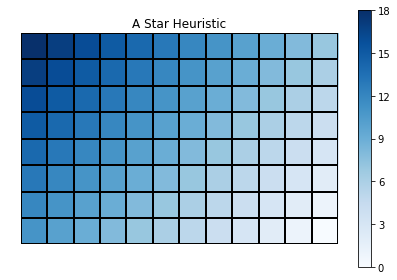

In [85]:
grid = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]

search_type = 0
name = ['A Star', 'Random Hueristic', 'Simple Search']

drawMap(grid, title='Map')

goal = [len(grid)-1, len(grid[0])-1]

if search_type == 0:  # gradient decent heuristic
    heuristic = calcHeuristic(grid, goal)
    drawMap(heuristic, cmap='Blues', title='A Star Heuristic')
elif search_type == 1:  # random heuristic
    heuristic = np.random.randint(0,8*12, (8,12), np.uint8)
    drawMap(heuristic, cmap='Blues', title='Random Heuristic')
elif search_type == 2:  # go back to the preivous simple search
    heuristic = np.zeros((8,12), dtype=np.uint8)
    # WARNING: drawMap doesn't handle a heuristic of all zeros
else:
    print('Crap ... something went wrong')

ans = a_star(grid,init,goal,cost,heuristic)
drawMap(ans, cmap='Purples', title=name[search_type])
print('start', init)
print('goal', goal)
path = getPath(ans, goal, init)
drawMap(grid, path, title=name[search_type])


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.